# Figure 3 and S3 - Hotspot Analysis

Reproducibility code for identifying fitness submodules from Yang\*, Jones\* et al, _bioRxiv_ 2021 

In [15]:
import hotspot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, cophenet, fclusterdata
from scipy.spatial.distance import squareform
import seaborn as sns


### Run Hotspot, reproduce analysis leading to Figure S3F

To note, there is a small amount of randomness in the _Hotspot_ algorithm, so the results below might not reproduce exactly the figures presented in our manuscript. However, generally there should be three clear clusters corresponding to those we describe.

In [3]:
# read in adata
data_directory = "/path/to/KPTracer-Data"
adata = sc.read(f'{data_directory}/expression/adata_processed.nt.h5ad')

mv_up_genes = pd.read_csv("./data/majority_vote.up_genes.sgNT.txt", sep='\t')['genes'].values
mv_down_genes = pd.read_csv("./data/majority_vote.down_genes.sgNT.txt", sep='\t')['genes'].values

In [4]:
scale_factor = np.median(np.array(adata.X.sum(axis=1)))

filt = adata.obs.apply(lambda x: 'Normal' not in x.Tumor and type(x.Tumor) == str, axis=1)
adata_filt = adata[filt,:]

mv_genes = mv_up_genes
adata_mv = adata_filt[:,mv_genes]

counts = pd.DataFrame(adata_mv.X.astype("float64").todense(), index = adata_mv.obs_names, columns = adata_mv.var_names).T
umi_counts = counts.sum(axis=0)
latent = pd.DataFrame(adata_mv.obsm['X_scVI'], index = adata_mv.obs_names)

hs = hotspot.Hotspot(counts, model='danb', latent=latent, umi_counts=umi_counts)
hs.create_knn_graph(weighted_graph=False, n_neighbors=int(np.sqrt(counts.shape[1])))

hs_results = hs.compute_autocorrelations(jobs=10)
hs_results.head(15)

/home/eecs/mattjones/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
100%|██████████| 1183/1183 [00:08<00:00, 138.17it/s]


,C,Z,Pval,FDR
Gene,,,,
Clu,0.882053,2809.220201,0.0,0.0
Krt19,0.727366,2288.652793,0.0,0.0
Krt7,0.705418,2236.153819,0.0,0.0
Tff1,0.584159,2033.337338,0.0,0.0
Vim,0.712284,1971.326580,0.0,0.0
Gkn2,0.510483,1855.007150,0.0,0.0
Ccnd2,0.646866,1808.099593,0.0,0.0
Fabp5,0.490335,1711.798260,0.0,0.0
Igfbp4,0.640435,1692.062367,0.0,0.0


In [5]:
hs_genes = hs_results.loc[hs_results.FDR < 0.05].sort_values('Z', ascending=False).index
lcz = hs.compute_local_correlations(hs_genes, jobs=20)

Computing pair-wise local correlation on 1183 features...


100%|██████████| 699153/699153 [6:04:51<00:00, 31.94it/s]   


In [6]:
def subcluster(hs, genes, desired_num_clusters = 2):
    
    dd = hs.local_correlation_z.loc[genes, genes].copy().values
    np.fill_diagonal(dd, 0)
    condensed = squareform(dd)*-1
    offset = condensed.min() * -1
    condensed += offset
    Z = linkage(condensed, method='average')
    
    clusters = fcluster(Z, t=desired_num_clusters, criterion='maxclust')
    return clusters

In [7]:
hs.local_correlation_z = lcz

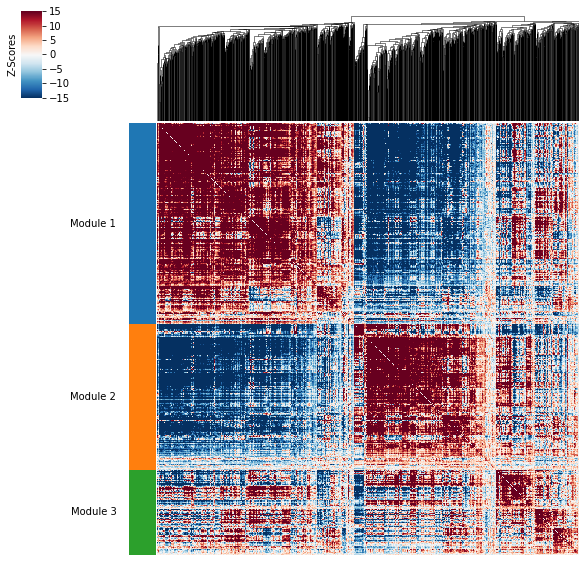

In [29]:
modules = hs.create_modules(
    min_gene_threshold=100, core_only=False, fdr_threshold=0.05
)

NUM_CLUSTERS = 3

dd = hs.local_correlation_z.copy().values
np.fill_diagonal(dd, 0)
condensed = squareform(dd)*-1
offset = condensed.min() * -1
condensed += offset
Z = linkage(condensed, method='ward')

clusters = fcluster(hs.linkage, t = NUM_CLUSTERS, criterion='maxclust')

modules = pd.DataFrame(clusters, index=hs.local_correlation_z.index).iloc[:,0]
hs.modules = None
hs.modules = modules
hs.modules.name = 'Module'

hs.plot_local_correlations(vmin=-15, vmax=15)
plt.show()

In [53]:
results = hs.results.join(hs.modules)

module = 2
for module in np.unique(hs.modules):
    if module != -1:
        print(results[results['Module'] == module].sort_values('Z', ascending=False).head(5))

               C            Z  Pval  FDR  Module
Gene                                            
Vim     0.712284  1971.326580   0.0  0.0       1
Ccnd2   0.646866  1808.099593   0.0  0.0       1
Igfbp4  0.640435  1692.062367   0.0  0.0       1
Lgals1  0.668398  1559.709413   0.0  0.0       1
Igfbp6  0.530061  1459.073008   0.0  0.0       1
              C            Z  Pval  FDR  Module
Gene                                           
Clu    0.882053  2809.220201   0.0  0.0       2
Krt19  0.727366  2288.652793   0.0  0.0       2
Krt7   0.705418  2236.153819   0.0  0.0       2
Tff1   0.584159  2033.337338   0.0  0.0       2
Gkn2   0.510483  1855.007150   0.0  0.0       2
              C           Z  Pval  FDR  Module
Gene                                          
Inhba  0.312053  816.988609   0.0  0.0       3
Kcnn4  0.215554  482.578745   0.0  0.0       3
Ncam1  0.241254  430.325207   0.0  0.0       3
Mif    0.309955  424.335537   0.0  0.0       3
Pilra  0.203800  419.880705   0.0  0.0 

### Figure  3G, S3G, 3H

There is some randomness to the Hotspot co-clustering, so here we read in the signature scores computed on the modules described in our manuscript.

In [80]:
sigscores = pd.read_csv("./data/signature_scores_sgNT.tsv", sep='\t', index_col = 0)


In [67]:
sigscores.head(5)

,FitnessMod3,FitnessMod1,FitnessMod2,FitnessSignature,REACTOME_CELL_CYCLE
L10.AAACCTGAGACGCAAC-1,1.097362,0.587823,0.704941,0.565690,0.573301
L10.AAACCTGAGAGTTGGC-1,1.095123,0.365713,0.534802,0.524223,0.472751
L10.AAACCTGAGCTCCTCT-1,1.153652,0.303960,0.400109,0.458081,0.533714
L10.AAACCTGAGGCAGGTT-1,1.028096,0.296160,0.336198,0.434050,0.496073
L10.AAACCTGAGTACACCT-1,1.079100,0.440309,0.371830,0.499492,0.478586


### Figure 3G

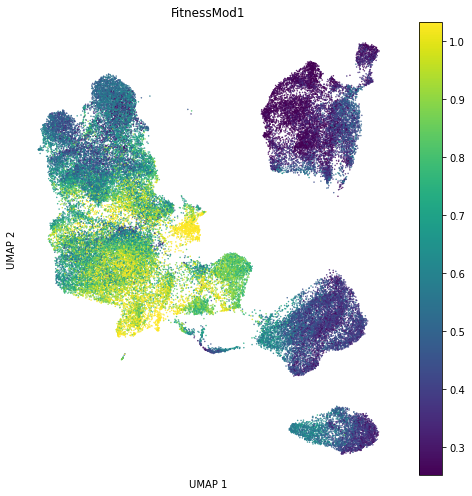

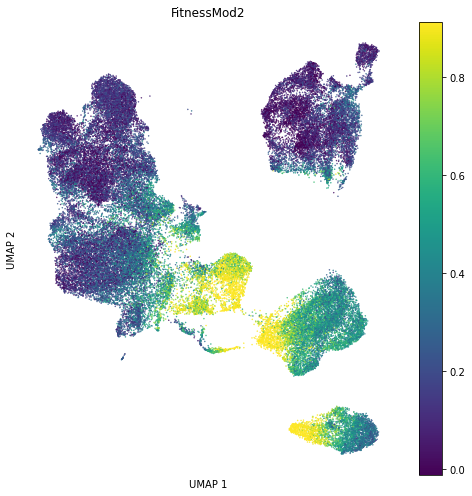

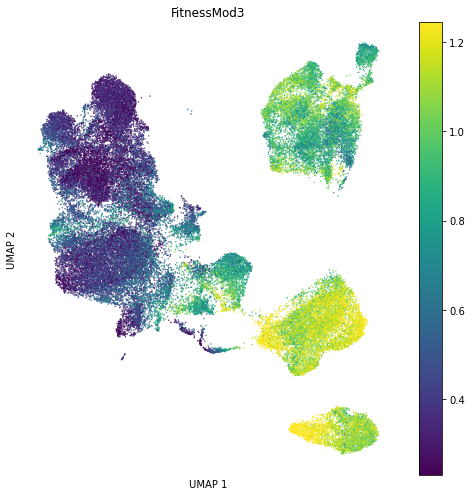

In [69]:
umap = pd.DataFrame(adata.obsm['X_umap'], index = adata.obs_names, columns = ['UMAP1', 'UMAP2'])
                    
for mod in ['FitnessMod1', 'FitnessMod2', 'FitnessMod3']:
    
    i = mod[-1]
    fig = plt.figure(figsize=(7,7))
    ax = plt.gca()
    ss = sigscores.loc[umap.index, mod]
    plt.scatter(umap['UMAP1'], umap['UMAP2'], cmap = 'viridis', s = 12000 / adata.shape[0],
                                c = ss, vmin=np.percentile(ss, 5), vmax = np.percentile(ss, 95))
    plt.title(f"{mod}")
    plt.xlabel('UMAP 1')
    plt.ylabel("UMAP 2")
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_frame_on(False)
    plt.colorbar()
    plt.tight_layout()
    # plt.savefig(f'fitness_hotspot_module{i}.png', dpi = 300, bbox_inches='tight')
    plt.show()

### Figure S3G

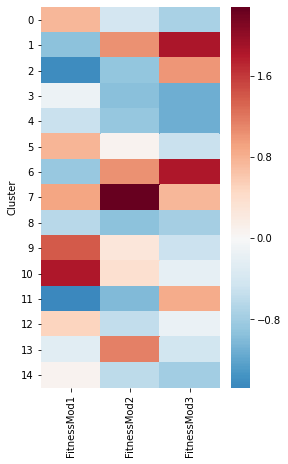

In [75]:
cluster_to_fitnessmod = pd.DataFrame(columns = ['Cluster', 'FitnessMod1', 'FitnessMod3', 'FitnessMod2'])
for cluster, grp in adata.obs.groupby('leiden_sub'):
    
    fitness1 = sigscores.loc[grp.index, 'FitnessMod1'].mean()
    fitness2 = sigscores.loc[grp.index, 'FitnessMod2'].mean()
    fitness3 = sigscores.loc[grp.index, 'FitnessMod3'].mean()
    
    new_df = pd.DataFrame([[cluster, fitness1, fitness3, fitness2]], columns = ['Cluster', 'FitnessMod1', 'FitnessMod3', 'FitnessMod2'])
    cluster_to_fitnessmod = pd.concat([cluster_to_fitnessmod, new_df])

# z-normalize columns
cluster_to_fitnessmod = cluster_to_fitnessmod.set_index('Cluster')
cluster_to_fitnessmod = cluster_to_fitnessmod.apply(lambda x: (x - x.mean()) / (x.std()), axis=0)

h = plt.figure(figsize = (4, 7))
g = sns.heatmap(cluster_to_fitnessmod[['FitnessMod1', 'FitnessMod2', 'FitnessMod3']], cmap = 'RdBu_r', center=0)
plt.yticks(rotation=0)
plt.show()

In [77]:
adata.layers['counts'] = adata.X.copy()

scale_factor = np.median(np.array(adata.X.sum(axis=1)))
adata.layers['logged'] = sc.pp.normalize_per_cell(adata, counts_per_cell_after = scale_factor, copy=True).X

sc.pp.log1p(adata, layer='logged')

/home/eecs/mattjones/.local/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


### Figure 3H

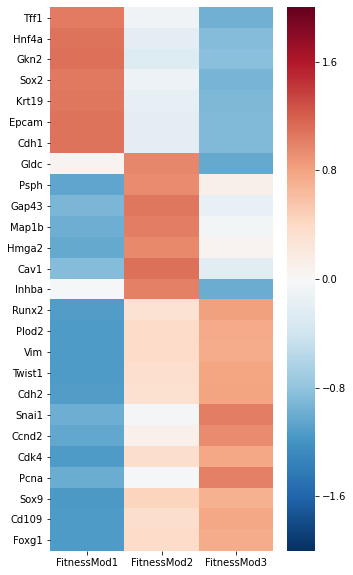

In [79]:
import scipy 

genes = ["Tff1", "Hnf4a", "Gkn2", "Sox2", "Krt19", "Epcam", "Cdh1", "Gldc", "Psph", "Gap43",
         "Map1b", "Hmga2", "Cav1", "Inhba", "Runx2", "Plod2", "Vim", "Twist1", "Cdh2", "Snai1",
         "Ccnd2", "Cdk4", "Pcna", "Sox9", "Cd109", "Foxg1"]

modules_to_gene_correlation = {}
for mod in ["FitnessMod1", "FitnessMod2", "FitnessMod3"]:
    
    modules_to_gene_correlation[mod] = {}
    for gene in genes:
        i = np.where(adata.var_names == gene)[0][0]
        modules_to_gene_correlation[mod][gene] = scipy.stats.pearsonr(adata.layers['logged'][:,i].toarray()[:,0], sigscores.loc[adata.obs_names, mod].values)[0]
        
modules_to_gene_correlation = pd.DataFrame.from_dict(modules_to_gene_correlation, orient='index')
        
fig = plt.figure(figsize=(5, 10))
modules_to_gene_correlation_norm = modules_to_gene_correlation.apply(lambda x: (x - x.mean()) / (x.std()), axis=0)
sns.heatmap(modules_to_gene_correlation_norm.T[['FitnessMod1', 'FitnessMod2', 'FitnessMod3']], cmap='RdBu_r', center=0, vmin=-2, vmax=2)
plt.show()